# Feature Engineering

Create features that help the machine learning algorithms find patterns in the data, and therefore perform the classification task better than when the algorithms are trained on raw data. 
   
Feature engineering transforms the raw data into a set of designed features. Cyclic-moment based features are widely used for the purpose of modulation recognition. A total of 32 features are designed in this notebook. The first 16 features are based on 0 cyclic time lag and the next 16 features are based on 8 cyclic time lag. The features are of the form 

\begin{equation}
s_{mn} = f_m\big(\left\{x_i^nx_{i+T}^n\right\}\big).
\end{equation}
which is the the $m$th order statistic on the $n$th power of the instantaneous or time delayed received signal $x_i$.

In [1]:
#Import the required modules

import numpy as np
import pickle  
import sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import os,random
import sys, math, cmath
from time import time
from IPython.display import Markdown, display
from collections import defaultdict

## Get the data

In [2]:
#Load the dataset

with open("RML2016.10a_dict.pkl",'rb') as f:
    Xd = pickle.load(f, encoding='latin1')
#we tell pickle.load() how to convert Python bytestring data to Python 3 strings, 
#or you can tell pickle to leave them as bytes.Setting the encoding to latin1 allows you to import the data directly

snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
# in map(function, input) format, input = Xd.keys(); we feed to variable x, one key at a time
# then we apply another map; from above, we got a list = [(mod type, SNR)]
# so to each pair; when we do (mod type, SNR)[0] we get the mod type; (mod type, SNR)[1] gives the SNR value
print('**Original dataset**')
print("Dataset has modulation types", mods)
print("and SNR values", snrs)

#delete analogue modulation and keep only digital modulation schemes

mods_to_rmv = ['AM-DSB', 'AM-SSB', 'WBFM']  #mod names we need to remove
keys_to_rmv = [key for key in Xd.keys() if key[0] in mods_to_rmv]  #keys corresponding to all these mods
# we remove each key containing each of the analog mod types
Xd_digital = {key: Xd[key] for key in Xd if key not in keys_to_rmv}  #new dictionary containing only digital mod types
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd_digital.keys())))), [1,0])
print("   ")
print('**New dataset**')
print("Limit dataset to",len(list(mods)), "digital modulation schemes:", mods)

**Original dataset**
Dataset has modulation types ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
and SNR values [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
   
**New dataset**
Limit dataset to 8 digital modulation schemes: ['8PSK', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK']


In [3]:
#Check samples assigned to keys - each (mod, SNR) pair in dictionary 

print('**Samples in dataset**')
array_shape = []
print("Dictionary contains", len(Xd_digital), "keys, meaning",len(Xd_digital),"(mod, SNR) pairs" )
for k,v in Xd_digital.items():
    array_shape.append(v.shape)
print("Each key or (mod,SNR) pair is assigned",set(array_shape), "array") 
print("This results in a total of",array_shape[0][0], "samples per (mod, SNR) pair, with each sample a",
      array_shape[0][1:3], "array")

**Samples in dataset**
Dictionary contains 160 keys, meaning 160 (mod, SNR) pairs
Each key or (mod,SNR) pair is assigned {(1000, 2, 128)} array
This results in a total of 1000 samples per (mod, SNR) pair, with each sample a (2, 128) array


## Separate training and test samples

In [11]:
#Separate samples for training and test sets

from sklearn.utils import shuffle

print('**Separate samples for training and testing**')

Xd_shuffled = dict()
        
#Randomize the samples assigned to each key 
# we take each key: (mod type, snr) pair, and shuffle the samples within this group of values
for k,v in Xd_digital.items():
        v = shuffle(v, random_state=0)
        Xd_shuffled.update({k : v})
# So Xd_shuffled is just Xd_digital with samples belonging to each key shuffled         
#set train:test set ratio
train_test = 0.5
dict_test = dict()
dict_train = dict()
test_array_shape = []
train_array_shape = []

#extract the first 'train_test' fraction of samples to form test set and the rest to form training set
for k,v in Xd_shuffled.items(): 
        dict_test.update({k : v[:int(v.shape[0]*0.25), :]}) 
        dict_train.update({k : v[int(v.shape[0]*0.25):, :]})
# Take each (mod type, SNR) key. From these 1000 samples assigned to the key, take the first half and put them in test set
# (we already shuffled these samples earlier)

#check samples assgined to each key in dictionary dict_test and dict_train
for k,v in dict_test.items(): test_array_shape.append(v.shape)        
for k,v in dict_train.items(): train_array_shape.append(v.shape)

print("Training:Test set ratio = ", train_test)
print("Each key in training set is assigned",set(train_array_shape), "array")
print("Each key in test set is assigned",set(test_array_shape), "array")
print("This results in:")
print("      training set: a total of",train_array_shape[0][0], "samples per (mod, SNR) pair")
print("      test set: a total of",test_array_shape[0][0], "samples per (mod, SNR) pair")

**Separate samples for training and testing**
Training:Test set ratio =  0.5
Each key in training set is assigned {(750, 2, 128)} array
Each key in test set is assigned {(250, 2, 128)} array
This results in:
      training set: a total of 750 samples per (mod, SNR) pair
      test set: a total of 250 samples per (mod, SNR) pair


From every (modulation, SNR) pair, randomly pick half the samples for training set

In [12]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], dict_train.keys())))), [1,0])
X_train = []  
labels_train = []
for mod in mods:
    for snr in snrs:
        X_train.append(dict_train[(mod,snr)])
        for i in range(dict_train[(mod,snr)].shape[0]): 
            labels_train.append((mod,snr))
X_train = np.vstack(X_train)
n_samples_train = X_train.shape[0]
y_train = np.array(list(map(lambda x: mods.index(labels_train[x][0]), range(n_samples_train))))

print("**Training data (raw data)**")
print(X_train.shape,"training data, ", y_train.shape, "labels")

**Training data (raw data)**
(120000, 2, 128) training data,  (120000,) labels


## First 16 features based on 0 cyclic time lag
Design features to transform raw data- each sample (2, 128) to feature vector of length 16

In [13]:
#Form expert features 

def form_features(X):
    
    #Form array of complex numbers; convert each (2,128) sample to a (128,) sample
    
    n_samples = X.shape[0]
    rows = X.shape[1]
    vec_len = X.shape[2]
    X_complex = []
    X_complex = [complex(X[samp_num,0,column],X[samp_num,1,column]) 
                 for samp_num in range(n_samples) for column in range(vec_len)]
    
    X_complex = np.vstack(X_complex)
    X_complex = np.reshape(X_complex, [n_samples,vec_len])
    X_complex_sqr = np.square(X_complex)
    X_complex_angl = np.angle(X_complex)
    
    #Form features: set of 16 expert features based on 0 cyclic time lag

    dict_16features = {}
    
    #Feature 1
    dict_16features['f1'] = np.array([np.mean(X_complex, axis=1)]).T

    #Feature 2
    dict_16features['f2'] = np.array([np.mean(abs(X_complex),axis = 1)]).T
    
    #Feature 3
    dict_16features['f3'] = np.array([np.mean(X_complex_angl, axis = 1)]).T

    #Feature 4
    dict_16features['f4'] = np.array([np.mean(abs(X_complex_angl), axis = 1)]).T

    #Feature 5
    dict_16features['f5'] = np.array([np.mean(X_complex_sqr, axis = 1)]).T

    #Feature 6
    dict_16features['f6'] = np.array([np.mean(np.square(abs(X_complex)), axis = 1)]).T

    #Feature 7
    dict_16features['f7'] = np.array([np.mean(np.square(X_complex_angl), axis = 1)]).T

    #Feature 8
    dict_16features['f8'] = np.array([np.mean(np.square(abs(X_complex_angl)), axis = 1)]).T

    #Feature 9
    dict_16features['f9'] = np.array([(np.mean(X_complex_sqr,axis = 1)) - 
                   ((1/vec_len**2)*np.square(np.sum(X_complex, axis = 1)))]).T

    #Feature 10
    dict_16features['f10'] = np.array([(np.mean(np.square(abs(X_complex)), axis = 1)) - 
                    ((1/vec_len**2)*np.square(np.sum(abs(X_complex), axis = 1)))]).T

    #Feature 11
    dict_16features['f11'] = np.array([(np.mean(np.square(X_complex_angl),axis = 1)) - 
                    ((1/vec_len**2)*np.square(np.sum(X_complex_angl, axis = 1)))]).T

    #Feature 12
    dict_16features['f12'] = np.array([(np.mean(np.square(abs(X_complex_angl)), axis = 1)) - 
                    ((1/vec_len**2)* np.square(np.sum(abs(X_complex_angl), axis = 1)))]).T

    #Feature 13
    dict_16features['f13'] = np.array([(np.mean(np.power(X_complex,4), axis = 1)) - 
                    ((1/vec_len**2)*(np.sum(X_complex_sqr,1))**2)]).T

    #Feature 14
    dict_16features['f14'] = np.array([(np.mean(np.power(abs(X_complex),4), axis = 1)) - 
                   ((1/vec_len**2)*(np.sum(np.square(abs(X_complex)), axis = 1))**2)]).T

    #Feature 15
    dict_16features['f15'] = np.array([(np.mean(np.power(X_complex_angl,4), axis =1)) - 
                   ((1/vec_len**2)*(np.sum(np.square(X_complex_angl),axis = 1))**2)]).T

    #Feature 16
    dict_16features['f16'] = np.array([(np.mean(np.power(abs(X_complex_angl),4), axis =1) - 
                   ((1/vec_len**2)*(np.sum(np.square(abs(X_complex_angl)),axis = 1))**2))]).T 

    #Concatenate 16 feature arrays
    X_16 = []
    X_16 += dict_16features.values()
    X_16 = abs(np.hstack(np.array(X_16)))
    
    return X_16

In [14]:
#Preprocess the training data

#shuffle the samples
X_train, y_train = shuffle(X_train, y_train)

#form features 
X_16_train = form_features(X_train)

#standardize the features
sc = StandardScaler()
sc.fit(X_16_train)
X_train_std = sc.transform(X_16_train)

print("**Training data after preprocessing**")
print("           - samples have", X_train_std.shape[1], "features")
print(X_train_std.shape,"training data, ", y_train.shape, "labels")

**Training data after preprocessing**
           - samples have 16 features
(120000, 16) training data,  (120000,) labels


## Create features for the test data
Use the same function for creating the test set. But unlike the training set, we keep track of the SNR for each sample in case of test set. This is because the performance/ accuracy of the trained ML algorithm depends on the SNR of the signal, and later an SNR vs. accuracy plot depicts how the algorithm does on samples corresponding to various SNRs. 

In [15]:
#Form and preprocess test data

# new defaultdict with keys = SNR values and values = (2,128) samples  
test_data = defaultdict(list)
test_labels = defaultdict(list)

# Extract all samples corresponding to each SNR value
# dict_test had keys of the form (mod type, SNR); new dict test_data has keys (SNR)
def form_test_data(snr):
    for k,v in dict_test.items():
        if k[1] == snr: 
            test_data[snr].append(v)
            for x in range(v.shape[0]): 
                test_labels[snr].append(k[0]) 
    test_data[snr] = np.vstack(test_data[snr])
    test_labels[snr] = np.vstack(test_labels[snr])
    n_samples_test = test_data[snr].shape[0]
    test_labels[snr] = np.array(list(map(lambda x: mods.index(test_labels[snr][x]), range(n_samples_test))))
    return test_data[snr], test_labels[snr]
    
X_test = defaultdict(list)
X_test16 = defaultdict(list)
y_test = defaultdict(list)
X_test_std = defaultdict(list)

# Extract samples and labels for each SNR 
for snr in snrs:
    data, labels = form_test_data(snr)     # extract all samples belonging to this SNR, from dict_test
    X_test[snr].append(data)
    X_test[snr] = np.vstack(X_test[snr])
    y_test[snr].append(labels)             # extract the corresponding labels belonging to this SNR, from dict_test
    y_test[snr] = np.hstack(y_test[snr])
    X_test[snr], y_test[snr] = shuffle(X_test[snr], y_test[snr])  #shuffle the samples (2, 128)
    X_test16[snr] = form_features(X_test[snr])   #form features; each sample is now (16,) feature vector 
    X_test_std[snr] = sc.transform(X_test16[snr])    #standardize the features
    
print("**Test data**")
print("Separate arrays for samples corresponding to different SNRs")
print("Total", len(snrs), X_test_std[18].shape, "arrays for SNR values", snrs)

**Test data**
Separate arrays for samples corresponding to different SNRs
Total 20 (2000, 16) arrays for SNR values [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


### Store variables in Jupyter's database

In [16]:
%store snrs
%store X_train_std
%store X_test_std
%store y_train
%store y_test

Stored 'snrs' (list)
Stored 'X_train_std' (ndarray)
Stored 'X_test_std' (defaultdict)
Stored 'y_train' (ndarray)
Stored 'y_test' (defaultdict)


## Next 16 features based on 8 cyclic time lag
Design next 16 features to transform raw data- each sample (2, 128) to feature vector of length 16 and then conmbine the previous 16 and these 16 features to form feature set consisting of 32 features

In [17]:
#Form expert features 

def form_next16_features(X):
    
    #Form array of complex numbers; convert each (2,128) sample to a (128,) sample
    
    n_samples = X.shape[0]
    rows = X.shape[1]
    vec_len = X.shape[2]
    X_complex = []
    X_complex = [complex(X[samp_num,0,column],X[samp_num,1,column]) 
                 for samp_num in range(n_samples) for column in range(vec_len)]
    
    X_complex = np.vstack(X_complex)
    X_complex = np.reshape(X_complex, [n_samples,vec_len])
    
    #Form array to use in features based on 8 cyclic time lag

    X_complex_8lag = np.zeros((X_complex.shape), dtype=complex)
    for samp_num in range(n_samples):
        for clmn in range(vec_len):
            shift_by = (clmn + 8)%vec_len
            X_complex_8lag[samp_num,clmn] = (X_complex[samp_num,clmn])*(X_complex[samp_num,shift_by])
            
    X_complex8_sqr = np.square(X_complex_8lag)
    X_complex8_angl = np.angle(X_complex_8lag)
    
    #16 expert features based on 8 cyclic time lag
    
    dict_16features = {}
    
    #Feature 17
    dict_16features['f17'] = np.array([np.mean(X_complex_8lag, axis = 1)]).T

    #Feature 18
    dict_16features['f18'] = np.array([np.mean(abs(X_complex_8lag),axis = 1)]).T

    #Feature 19
    dict_16features['f19'] = np.array([np.mean(X_complex8_angl, axis = 1)]).T

    #Feature 20
    dict_16features['f20'] = np.array([np.mean(abs(X_complex8_angl), axis = 1)]).T

    #Feature 21
    dict_16features['f21'] = np.array([np.mean(X_complex8_sqr, axis = 1)]).T

    #Feature 22
    dict_16features['f22'] = np.array([np.mean(np.square(abs(X_complex_8lag)), axis = 1)]).T

    #Feature 23
    dict_16features['f23'] = np.array([np.mean(np.square(X_complex8_angl), axis = 1)]).T

    #Feature 24
    dict_16features['f24'] = np.array([np.mean(np.square(abs(X_complex8_angl)), axis = 1)]).T

    #Feature 25
    dict_16features['f25'] = np.array([(np.mean(X_complex8_sqr,axis = 1)) - 
                    ((1/vec_len**2)*np.square(np.sum(X_complex_8lag, axis = 1)))]).T

    #Feature 26
    dict_16features['f26'] = np.array([(np.mean(np.square(abs(X_complex_8lag)), axis = 1)) -
                    ((1/vec_len**2)*np.square(np.sum(abs(X_complex_8lag), axis = 1)))]).T

    #Feature 27
    dict_16features['f27'] = np.array([(np.mean(np.square(X_complex8_angl),axis = 1)) -
              ((1/vec_len**2)*np.square(np.sum(X_complex8_angl, axis = 1)))]).T

    #Feature 28
    dict_16features['f28'] = np.array([(np.mean(np.square(abs(X_complex8_angl)), axis = 1)) - 
             ((1/vec_len**2)* np.square(np.sum(abs(X_complex8_angl), axis = 1)))]).T

    #Feature 29
    dict_16features['f29'] = np.array([(np.mean(np.power(X_complex_8lag,4), axis = 1)) - 
                    ((1/vec_len**2)*(np.sum(X_complex8_sqr,1))**2)]).T

    #Feature 30
    dict_16features['f30'] = np.array([(np.mean(np.power(abs(X_complex_8lag),4), axis = 1)) - 
             ((1/vec_len**2)*(np.sum(np.square(abs(X_complex_8lag)), axis = 1))**2)]).T

    #Feature 31
    dict_16features['f31'] = np.array([((1/vec_len)* np.sum(np.power(X_complex8_angl,4), axis =1)) - 
                     ((1/vec_len**2)*(np.sum(np.square(X_complex8_angl),axis = 1))**2)]).T

    #Feature 32
    dict_16features['f32'] = np.array([(np.mean(np.power(abs(X_complex8_angl),4), axis =1) - 
             ((1/vec_len**2)*(np.sum(np.square(abs(X_complex8_angl)),axis = 1))**2))]).T

    #Concatenate 16 feature arrays
    X_16 = []
    X_16 += dict_16features.values()
    X_16 = abs(np.hstack(np.array(X_16)))
    
    return X_16

In [18]:
#Preprocess the training data

#form features 
X_next16_train = form_next16_features(X_train)

# combine the previous 16 features with these next 16 features, to create (n_samples, 32) data
X_32_train = np.concatenate((X_16_train, X_next16_train), axis = 1)

#standardize the features
sc = StandardScaler()
sc.fit(X_32_train)
X_32train_std = sc.transform(X_32_train)

print("**Training data after preprocessing**")
print("           - samples have", X_32train_std.shape[1], "features")
print(X_32train_std.shape,"training data, ", y_train.shape, "labels")

**Training data after preprocessing**
           - samples have 32 features
(120000, 32) training data,  (120000,) labels


In [19]:
#Form and preprocess test data
    
X_next16test = defaultdict(list)
X_32test_std = defaultdict(list)
X_32test = defaultdict(list)

for snr in snrs:
    X_next16test[snr] = form_next16_features(X_test[snr])   # form the next 16 features
    # concatenate the previous 16 and these next 16 features, so total 32 features
    X_32test[snr] = np.concatenate((X_test16[snr], X_next16test[snr]), axis = 1)   
    X_32test_std[snr] = sc.transform(X_32test[snr])    #standardize the features
    
print("**Test data**")
print("Separate arrays for samples corresponding to different SNRs")
print("Total", len(snrs), X_32test_std[18].shape, "arrays for SNR values", snrs)

**Test data**
Separate arrays for samples corresponding to different SNRs
Total 20 (2000, 32) arrays for SNR values [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [20]:
y_32_train = y_train
y_32_test = y_test

## Store variables in Jupyter's database

In [21]:
%store X_32train_std
%store X_32test_std
%store y_32_train
%store y_32_test

Stored 'X_32train_std' (ndarray)
Stored 'X_32test_std' (defaultdict)
Stored 'y_32_train' (ndarray)
Stored 'y_32_test' (defaultdict)


## View all stored variables

In [22]:
%store

Stored variables and their in-db values:
X_32test_std              -> defaultdict(<class 'list'>, {-20: array([[-1.05249
X_32train_std             -> array([[-7.15400182e-01, -6.40676641e-01, -1.36428
X_test_std                -> defaultdict(<class 'list'>, {-20: array([[-1.05249
X_train_std               -> array([[-7.15400182e-01, -6.40676641e-01, -1.36428
snrs                      -> [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 
y_32_test                 -> defaultdict(<class 'list'>, {-20: array([7, 6, 2, 
y_32_train                -> array([2, 3, 3, ..., 3, 6, 1])
y_test                    -> defaultdict(<class 'list'>, {-20: array([7, 6, 2, 
y_train                   -> array([2, 3, 3, ..., 3, 6, 1])


## Decision Tree and Ensemble Learning

In [23]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from collections import defaultdict
from time import time
import pickle  
import sklearn
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
%store -r
%store

Stored variables and their in-db values:
X_32test_std              -> defaultdict(<class 'list'>, {-20: array([[-1.05249
X_32train_std             -> array([[-7.15400182e-01, -6.40676641e-01, -1.36428
X_test_std                -> defaultdict(<class 'list'>, {-20: array([[-1.05249
X_train_std               -> array([[-7.15400182e-01, -6.40676641e-01, -1.36428
snrs                      -> [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 
y_32_test                 -> defaultdict(<class 'list'>, {-20: array([7, 6, 2, 
y_32_train                -> array([2, 3, 3, ..., 3, 6, 1])
y_test                    -> defaultdict(<class 'list'>, {-20: array([7, 6, 2, 
y_train                   -> array([2, 3, 3, ..., 3, 6, 1])


In [24]:
print("Training data: ", X_train_std.shape, "and labels: ", y_train.shape)
print(" ")
print("Test data:")
print("Total", len(X_test_std), X_test_std[18].shape, "arrays for SNR values:")
print(X_test_std.keys())

Training data:  (120000, 16) and labels:  (120000,)
 
Test data:
Total 20 (2000, 16) arrays for SNR values:
dict_keys([-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18])


In [25]:
#Train the classifier

params = {'max_depth': list(range(9,18)),'max_leaf_nodes': list(range(50, 150)), 'min_samples_split': [2,3,4],
          'max_features': [None,'auto','sqrt','log2'], 'criterion':['gini', 'entropy']}

rand_search_cv = RandomizedSearchCV(RandomForestClassifier(random_state=42), params, verbose=0)

start = time()
print("Train decision tree classifier - randomized search for parameter optimization")
rand_search_cv.fit(X_train_std, y_train)
print("Randomized search took %.2f minutes "%((time() - start)//60))
print("   ")
print("Result of randomized search:")
print(rand_search_cv.best_estimator_)

Train decision tree classifier - randomized search for parameter optimization
Randomized search took 4.00 minutes 
   
Result of randomized search:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=13, max_features=None, max_leaf_nodes=149,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [26]:
#Test the classifier

import collections

y_pred = defaultdict(list)
accuracy = defaultdict(list)

print("Test the classifier")
print(" ")
for snr in snrs:
    y_pred[snr] = rand_search_cv.predict(X_test_std[snr])
    accuracy[snr] = metrics.accuracy_score(y_test[snr], y_pred[snr])
    print("Decision Tree's accuracy on %d dB SNR samples = "%(snr), accuracy[snr])   
    
accuracy = collections.OrderedDict(sorted(accuracy.items()))  #sort by ascending SNR value

Test the classifier
 
Decision Tree's accuracy on -20 dB SNR samples =  0.128
Decision Tree's accuracy on -18 dB SNR samples =  0.1205
Decision Tree's accuracy on -16 dB SNR samples =  0.1365
Decision Tree's accuracy on -14 dB SNR samples =  0.1275
Decision Tree's accuracy on -12 dB SNR samples =  0.1335
Decision Tree's accuracy on -10 dB SNR samples =  0.187
Decision Tree's accuracy on -8 dB SNR samples =  0.2955
Decision Tree's accuracy on -6 dB SNR samples =  0.3785
Decision Tree's accuracy on -4 dB SNR samples =  0.4055
Decision Tree's accuracy on -2 dB SNR samples =  0.443
Decision Tree's accuracy on 0 dB SNR samples =  0.493
Decision Tree's accuracy on 2 dB SNR samples =  0.6255
Decision Tree's accuracy on 4 dB SNR samples =  0.7655
Decision Tree's accuracy on 6 dB SNR samples =  0.813
Decision Tree's accuracy on 8 dB SNR samples =  0.8075
Decision Tree's accuracy on 10 dB SNR samples =  0.8285
Decision Tree's accuracy on 12 dB SNR samples =  0.8265
Decision Tree's accuracy on 14

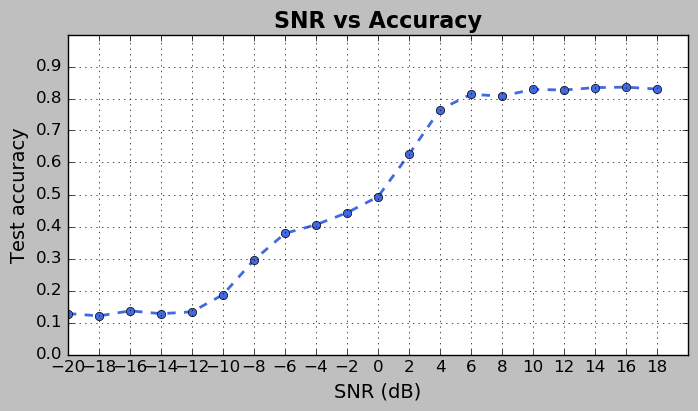

In [27]:
plt.style.use('classic')

fig = plt.figure(figsize=(8, 4), dpi=100)
x = snrs
y = list(accuracy.values())
plt.plot(x, y, marker="o", linewidth=2.0, linestyle='dashed', color='royalblue')
plt.axis([-20, 20, 0, 1])
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.yticks(np.arange(0, 1, 0.10))

ttl = plt.title('SNR vs Accuracy', fontsize=16)
ttl.set_weight('bold')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.grid()

plt.show()

In [28]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
import pandas as pd

classes = ['8PSK', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK']
y_predicted = rand_search_cv.predict(X_test_std[18])
conf_matrix = confusion_matrix(y_predicted, y_test[18]) 

df = pd.DataFrame(data = conf_matrix, columns = classes, index = classes) 
print("Confusion Matrix Without Normalization")
print(df)

Confusion Matrix Without Normalization
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK    216     0      0     0     1     21     27     4
BPSK      1   247      0     0     9      1      2     0
CPFSK     9     0    233     5     0      0      2     1
GFSK      3     1     17   245     1      4      5     0
PAM4      0     2      0     0   239      3      2     2
QAM16     6     0      0     0     0     69     42     0
QAM64     6     0      0     0     0    139    168     1
QPSK      9     0      0     0     0     13      2   242


Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.80  0.00   0.00  0.00  0.00   0.08   0.10  0.01
BPSK   0.00  0.95   0.00  0.00  0.03   0.00   0.01  0.00
CPFSK  0.04  0.00   0.93  0.02  0.00   0.00   0.01  0.00
GFSK   0.01  0.00   0.06  0.89  0.00   0.01   0.02  0.00
PAM4   0.00  0.01   0.00  0.00  0.96   0.01   0.01  0.01
QAM16  0.05  0.00   0.00  0.00  0.00   0.59   0.36  0.00
QAM64  0.02  0.00   0.00  0.00  0.00   0.44   0.54  0.00
QPSK   0.03  0.00   0.00  0.00  0.00   0.05   0.01  0.91


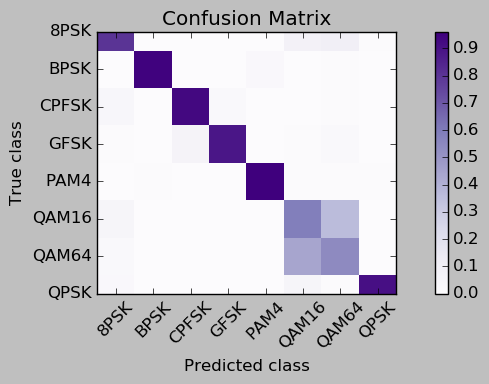

In [29]:
#Normalize the matrix

conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.round(decimals = 2)

df = pd.DataFrame(data = conf_matrix, columns = classes, index = classes) 
print("Confusion Matrix")
print(df)

fig1 = plt.figure(figsize=(8, 4), dpi=100)
plt.imshow(conf_matrix, interpolation = 'nearest', cmap = plt.cm.Purples)
ticks = np.arange(len(classes))
plt.title("Confusion Matrix")
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

plt.ylabel('True class')
plt.xlabel('Predicted class')

plt.tight_layout()
plt.colorbar()
plt.show()

In [30]:
from sklearn.externals import joblib

joblib.dump(rand_search_cv, "random_tree.pkl")

['random_tree.pkl']

In [31]:
import pickle
from sklearn.externals import joblib
rand_search_cv = joblib.load("random_tree.pkl")